In [ ]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import matplotlib.patches as patches
import albumentations as alb
from tensorflow.keras import layers, models, Input

os.getcwd()

In [ ]:
# Load image and display one
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

train_images = tf.data.Dataset.list_files('data/images/*.png', shuffle=False)

train_images = train_images.map(load_image)
iterator = train_images.as_numpy_iterator()
s = iterator.next()

plt.imshow(s)
print(s.shape)
plt.axis('off')  # Turn off axis
plt.show()


In [ ]:
# No. of images in each dataset
print(len(glob(os.path.join("aug_data/train/images", "*.jpg"))))
print(len(glob(os.path.join("aug_data/val/images", "*.jpg"))))
print(len(glob(os.path.join("aug_data/test/images", "*.jpg"))))

In [ ]:
import tensorflow as tf
import json
import os

def parse_json_file(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    if data['shapes']:  
        label = 1
        points = data['shapes'][0]['points']
        points = [point for sublist in points for point in sublist]
    else:  # No cavity
        label = 0
        points = [0.0, 0.0, 0.0, 0.0]
    
    return label, points

def load_image(image_path):
    image = tf.io.read_file(image_path)
    # Dynamically decode image based on its format
    if image_path.endswith('.jpg'):
        image = tf.image.decode_jpeg(image, channels=3)
    elif image_path.endswith('.png'):
        image = tf.image.decode_png(image, channels=3)
    # Resize images for Inception-v3
    image = tf.image.resize(image, [299, 299])  
    # Preprocess images for Inception-v3
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def load_dataset(labels_dir, images_dir):
    images = []
    labels = []
    points = []
    
    for file in os.listdir(labels_dir):
        if file.endswith('.json'):
            json_path = os.path.join(labels_dir, file)
            # Construct paths for both possible image formats
            image_file_jpg = file.replace('.json', '.jpg')
            image_file_png = file.replace('.json', '.png')
            image_path_jpg = os.path.join(images_dir, image_file_jpg)
            image_path_png = os.path.join(images_dir, image_file_png)
            
            # Determine which image file exists
            if os.path.exists(image_path_jpg):
                image_path = image_path_jpg
            elif os.path.exists(image_path_png):
                image_path = image_path_png
            else:
                continue  # Skip if no corresponding image exists
            
            label, point = parse_json_file(json_path)
            image = load_image(image_path)
                    
            images.append(image)
            labels.append(label)
            points.append(point)
    
    # Convert lists to tensors
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    points = tf.convert_to_tensor(points, dtype=tf.float32)
    
    def gen():
        for i in range(len(images)):
            yield images[i], labels[i], points[i]
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32, tf.float32),
        output_shapes=((299, 299, 3), (), (4,))
    )
    
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
    return dataset

# Paths to the directories
labels_dir = 'aug_data/train/labels'
images_dir = 'aug_data/train/images'

# Load the dataset
dataset = load_dataset(labels_dir, images_dir)

# Example to iterate over the dataset
for image, label, points in dataset.take(1):
    print(f'Image shape: {image.shape}, Label: {label}, Points: {points}')


In [ ]:
train_labels_dir = 'aug_data/train/labels'
train_images_dir = 'aug_data/train/images'
train_dataset = load_dataset(train_labels_dir, train_images_dir)

val_labels_dir = 'aug_data/val/labels'
val_images_dir = 'aug_data/val/images'
val_dataset = load_dataset(val_labels_dir, val_images_dir)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization



from tensorflow.keras.layers import Dropout

# def build_model(num_classes=1, num_coordinates=4, dropout_rate=0.5):
#     base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
#     # Freeze the base model layers
#     base_model.trainable = False
    
#     # Add custom layers
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)  # Add dropout
#     x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x) # Additional Dense layer
#     x = Dropout(dropout_rate)(x)  # Add dropout
    
#     # Output layer for classification
#     classification_output = Dense(num_classes, activation='sigmoid', name='classification_output')(x)
    
#     # Output layer for bounding box coordinates
#     bounding_box_output = Dense(num_coordinates, activation='linear', name='bounding_box_output')(x)
    
#     model = Model(inputs=base_model.input, outputs=[classification_output, bounding_box_output])
    
#     return model

def build_model(num_classes=1, num_coordinates=4, dropout_rate=0.5):
    base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Dropout(dropout_rate)(x)
    
    classification_output = Dense(num_classes, activation='sigmoid', name='classification_output')(x)
    bounding_box_output = Dense(num_coordinates, activation='linear', name='bounding_box_output')(x)
    
    model = Model(inputs=base_model.input, outputs=[classification_output, bounding_box_output])
    
    return model


model = build_model()


def gen():
    for i in range(len(images)):
        classification_label = np.array([labels[i]])  # Making sure it's of shape [1]
        bounding_box = np.array(points[i])  # Ensuring it's an array of shape [4]
        yield images[i], {'classification_output': classification_label, 'bounding_box_output': bounding_box}
        
dataset = tf.data.Dataset.from_generator(
    gen,
    output_types=(tf.float32, {'classification_output': tf.int32, 'bounding_box_output': tf.float32}),
    output_shapes=((299, 299, 3), {'classification_output': (), 'bounding_box_output': (4,)}))


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

def adjust_dataset(dataset):
    def format_function(image, classification_label, bounding_box):
        return image, {'classification_output': classification_label, 'bounding_box_output': bounding_box}
    
    # Apply the format_function to each element in the dataset
    adjusted_dataset = dataset.map(format_function)
    return adjusted_dataset

# Apply the adjustment to both the training and validation datasets
train_dataset = adjust_dataset(train_dataset)
val_dataset = adjust_dataset(val_dataset)



In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler

# # Function to decay the learning rate
# def lr_schedule(epoch, lr):
#     if epoch > 10:
#         return lr * 0.1
#     return lr

# # Add this to your callbacks list along with early stopping
# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# callbacks_list = [early_stopping, lr_scheduler]

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

callbacks_list = [early_stopping, reduce_lr]

In [8]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss={'classification_output': 'binary_crossentropy',
                    'bounding_box_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy',
                       'bounding_box_output': 'mse'})

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)


Epoch 1/10
456/456 [==============================] - 250s 538ms/step - loss: 2.5045 - classification_output_loss: 0.5661 - bounding_box_output_loss: 1.2591 - classification_output_accuracy: 0.7259 - bounding_box_output_mse: 1.2591 - val_loss: 1.6511 - val_classification_output_loss: 0.6894 - val_bounding_box_output_loss: 0.2869 - val_classification_output_accuracy: 0.6863 - val_bounding_box_output_mse: 0.2869 - lr: 1.0000e-04
Epoch 2/10
456/456 [==============================] - 247s 541ms/step - loss: 1.2827 - classification_output_loss: 0.2613 - bounding_box_output_loss: 0.3525 - classification_output_accuracy: 0.8977 - bounding_box_output_mse: 0.3525 - val_loss: 1.7683 - val_classification_output_loss: 0.8506 - val_bounding_box_output_loss: 0.2554 - val_classification_output_accuracy: 0.6948 - val_bounding_box_output_mse: 0.2554 - lr: 1.0000e-04
Epoch 3/10
456/456 [==============================] - ETA: 0s - loss: 1.0233 - classification_output_loss: 0.1489 - bounding_box_output_lo

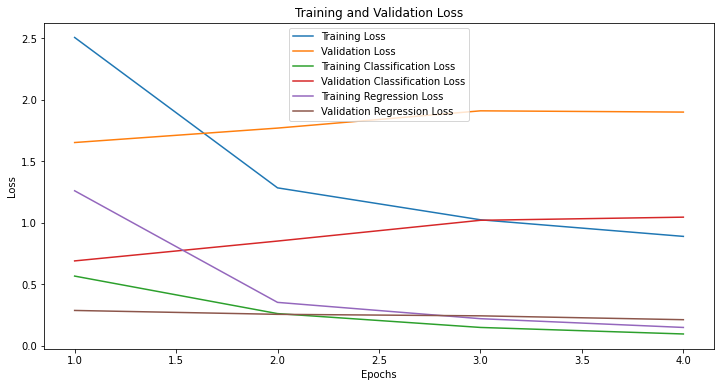

In [9]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_classification_loss = history.history['classification_output_loss']
validation_classification_loss = history.history['val_classification_output_loss']
training_regression_loss = history.history['bounding_box_output_loss']
validation_regression_loss = history.history['val_bounding_box_output_loss']

# Epochs range
epochs_range = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot for overall loss
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')

plt.plot(epochs_range, training_classification_loss, label='Training Classification Loss')
plt.plot(epochs_range, validation_classification_loss, label='Validation Classification Loss')
plt.plot(epochs_range, training_regression_loss, label='Training Regression Loss')
plt.plot(epochs_range, validation_regression_loss, label='Validation Regression Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [53]:
history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset,
    callbacks=[early_stopping]  
)

Epoch 1/10
456/456 [==============================] - 246s 529ms/step - loss: 0.4747 - classification_output_loss: 0.3875 - bounding_box_output_loss: 0.0871 - classification_output_accuracy: 0.8523 - bounding_box_output_mse: 0.0871 - val_loss: 0.8797 - val_classification_output_loss: 0.7299 - val_bounding_box_output_loss: 0.1498 - val_classification_output_accuracy: 0.7111 - val_bounding_box_output_mse: 0.1498
Epoch 2/10
456/456 [==============================] - 218s 477ms/step - loss: 0.2146 - classification_output_loss: 0.1751 - bounding_box_output_loss: 0.0395 - classification_output_accuracy: 0.9610 - bounding_box_output_mse: 0.0395 - val_loss: 1.0500 - val_classification_output_loss: 0.9087 - val_bounding_box_output_loss: 0.1413 - val_classification_output_accuracy: 0.7150 - val_bounding_box_output_mse: 0.1413
Epoch 3/10
456/456 [==============================] - 249s 546ms/step - loss: 0.1335 - classification_output_loss: 0.1049 - bounding_box_output_loss: 0.0286 - classificatio

In [56]:
history.history

{'loss': [0.474651575088501,
  0.21459536254405975,
  0.13345026969909668,
  0.09579111635684967],
 'classification_output_loss': [0.38754358887672424,
  0.17509345710277557,
  0.1048668771982193,
  0.0714910477399826],
 'bounding_box_output_loss': [0.0871080756187439,
  0.039501819759607315,
  0.02858344465494156,
  0.02430012635886669],
 'classification_output_accuracy': [0.8523319363594055,
  0.9610425233840942,
  0.9803155064582825,
  0.9862825870513916],
 'bounding_box_output_mse': [0.0871080756187439,
  0.039501819759607315,
  0.02858344465494156,
  0.02430012635886669],
 'val_loss': [0.8797416687011719,
  1.0500209331512451,
  1.2027162313461304,
  1.3335188627243042],
 'val_classification_output_loss': [0.7299151420593262,
  0.9086775779724121,
  1.0671510696411133,
  1.2007198333740234],
 'val_bounding_box_output_loss': [0.14982658624649048,
  0.14134353399276733,
  0.1355651170015335,
  0.13279925286769867],
 'val_classification_output_accuracy': [0.7111111283302307,
  0.7150

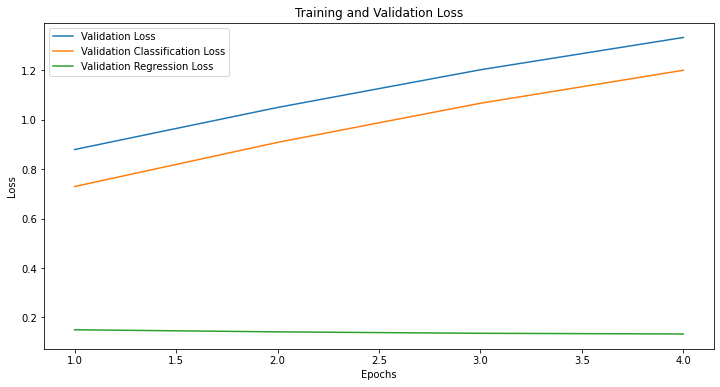

In [59]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_classification_loss = history.history['classification_output_loss']
validation_classification_loss = history.history['val_classification_output_loss']
training_regression_loss = history.history['bounding_box_output_loss']
validation_regression_loss = history.history['val_bounding_box_output_loss']

# Epochs range
epochs_range = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot for overall loss
#plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')

#plt.plot(epochs_range, training_classification_loss, label='Training Classification Loss')
plt.plot(epochs_range, validation_classification_loss, label='Validation Classification Loss')
#plt.plot(epochs_range, training_regression_loss, label='Training Regression Loss')
plt.plot(epochs_range, validation_regression_loss, label='Validation Regression Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np

test_dataset = adjust_dataset(test_dataset)

results = model.evaluate(test_dataset)


classification_accuracy = results[3]  
bounding_box_mse = results[4]

print(f"Classification accuracy on test data: {classification_accuracy * 100:.2f}%")
print(f"Bounding box mean squared error on test data: {bounding_box_mse}")


In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def visualize_predicted_image_opencv(image_path, coordinates):
    # Load the original image
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Denormalize the bounding box coordinates
    x_min, y_min, x_max, y_max = coordinates
    x_min_denorm = int(x_min * width)
    y_min_denorm = int(y_min * height)
    x_max_denorm = int(x_max * width)
    y_max_denorm = int(y_max * height)

    # Draw the bounding box on the image
    cv2.rectangle(image, (x_min_denorm, y_min_denorm), (x_max_denorm, y_max_denorm), (0, 255, 0), 2)

    # Display the image
    cv2.imshow('Predicted Image', image)
    cv2.waitKey(0)  # Wait for a key press to close
    cv2.destroyAllWindows()


image_path = 'aug_data/test/images/90_aug_20.png'
preprocessed_image = load_image(image_path)
image_batch = tf.expand_dims(preprocessed_image, 0)  # Adds a batch dimension

predictions = model.predict(image_batch)

classification_pred = predictions[0]  
regression_pred = predictions[1] 
coordinates = regression_pred[0] 

# Visualize the predicted bounding box
visualize_predicted_image_opencv(image_path, coordinates)


1/1 [==============================] - 3s 3s/step
